# Cricket Match Outcome EDA

This notebook explores the training dataset `cricket_dataset.csv` and compares with `cricket_dataset_test.csv`.

Goals:
- Understand schema and data quality
- Explore target distribution and key drivers
- Visualize univariate and bivariate relationships
- Assess correlations and potential leakage
- Compare train/test feature distributions
- Summarize insights for modeling


In [7]:
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

# Plot style
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

# Paths
BASE_DIR = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parents[0]
DATA_TRAIN = BASE_DIR / 'cricket_dataset.csv'
DATA_TEST = BASE_DIR / 'cricket_dataset_test.csv'
print(f'Train: {DATA_TRAIN}')
print(f'Test : {DATA_TEST}')


Train: c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\cricket_dataset.csv
Test : c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\cricket_dataset_test.csv


In [8]:
# Load data
train_df = pd.read_csv(DATA_TRAIN)
test_df = pd.read_csv(DATA_TEST)

print('Train shape:', train_df.shape)
print('Test shape :', test_df.shape)
train_df.head()


Train shape: (15691, 5)
Test shape : (627, 4)


,total_runs,wickets,target,balls_left,won
0,0.0,0.0,125,119.0,1
1,0.0,0.0,125,118.0,1
2,1.0,0.0,125,117.0,1
3,1.0,1.0,125,116.0,1
4,1.0,1.0,125,115.0,1


In [9]:
# Overview: dtypes, basic stats
print('Columns:', list(train_df.columns))
train_df.dtypes.to_frame('dtype')


Columns: ['total_runs', 'wickets', 'target', 'balls_left', 'won']


,dtype
total_runs,float64
wickets,float64
target,int64
balls_left,float64
won,int64


In [10]:
# Summary statistics for numeric columns
train_df.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
total_runs,15689.0,71.395691,45.430853,0.0,34.0,68.0,105.0,203.0
wickets,15689.0,2.538530,2.153691,0.0,1.0,2.0,4.0,10.0
target,15691.0,156.716462,28.713984,59.0,136.0,156.0,180.0,238.0
balls_left,15689.0,63.766652,33.006166,-3.0,36.0,65.0,92.0,119.0
won,15691.0,0.621184,0.485108,0.0,0.0,1.0,1.0,1.0


Missing (train):
total_runs    2
wickets       2
balls_left    2
dtype: int64

Missing (test):
Series([], dtype: int64)


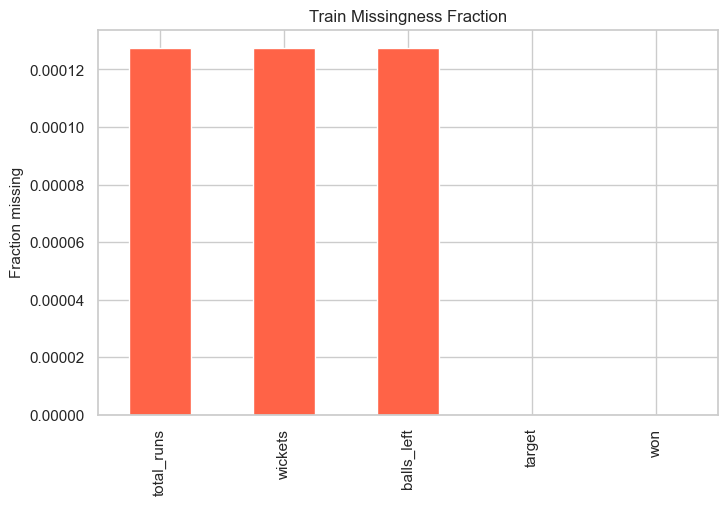

In [11]:
# Missing values analysis
missing_train = train_df.isna().sum().sort_values(ascending=False)
missing_test = test_df.isna().sum().sort_values(ascending=False)

print('Missing (train):')
print(missing_train[missing_train > 0])
print('\nMissing (test):')
print(missing_test[missing_test > 0])

# Visualize missingness if any
if missing_train.sum() > 0:
    ax = (missing_train / len(train_df)).plot(kind='bar', color='tomato', title='Train Missingness Fraction')
    ax.set_ylabel('Fraction missing')
    plt.show()
else:
    print('No missing values in train.')


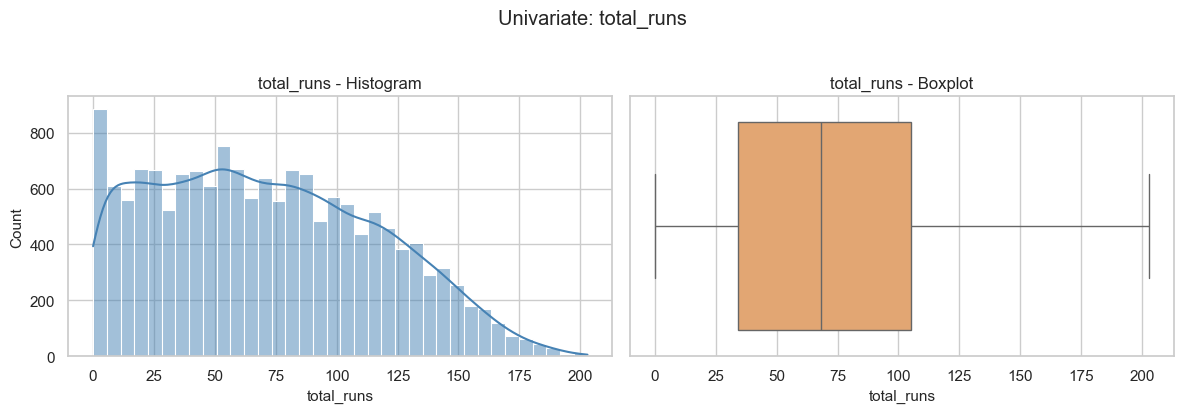

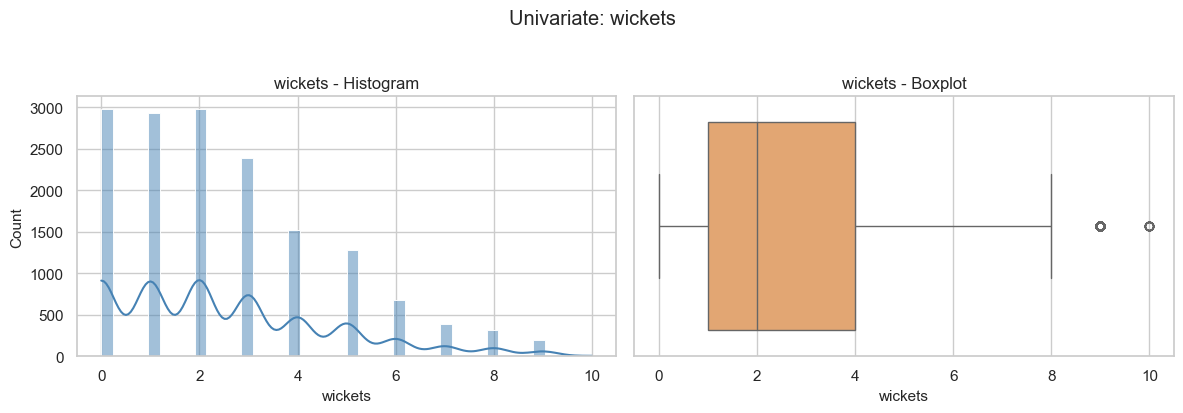

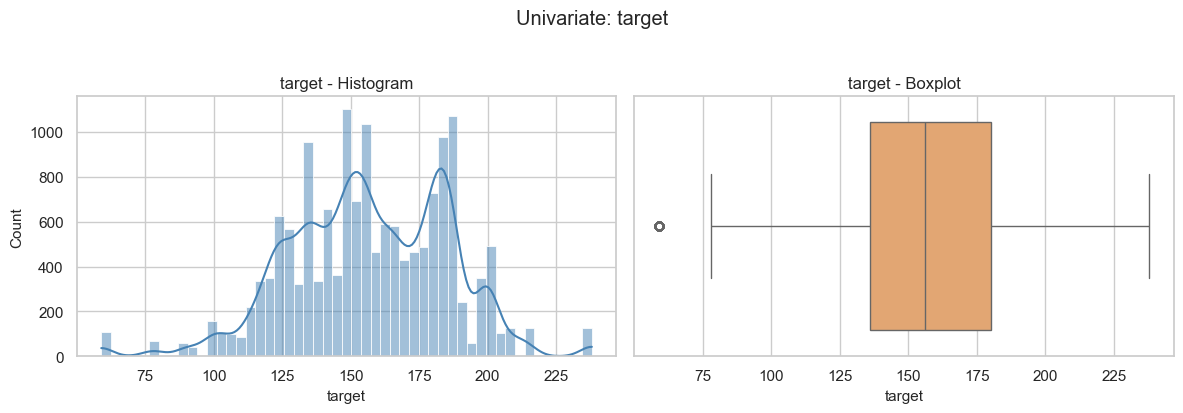

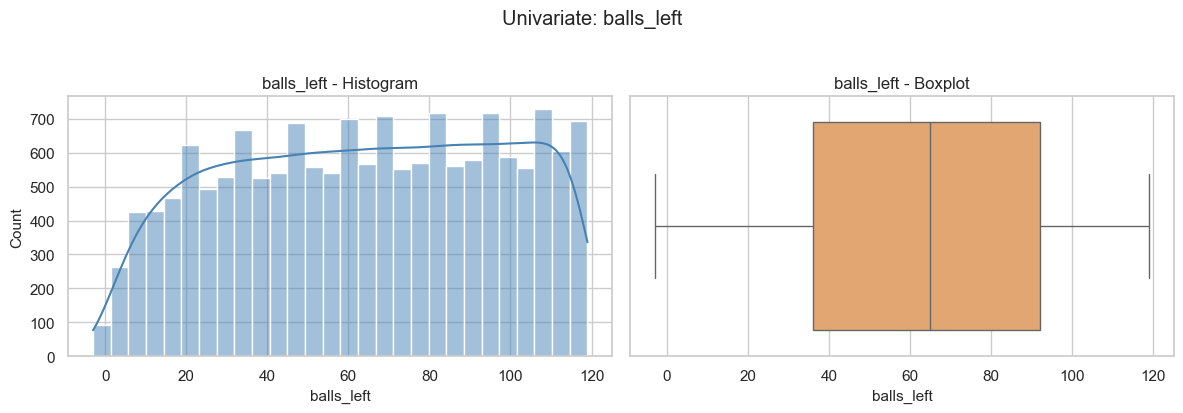

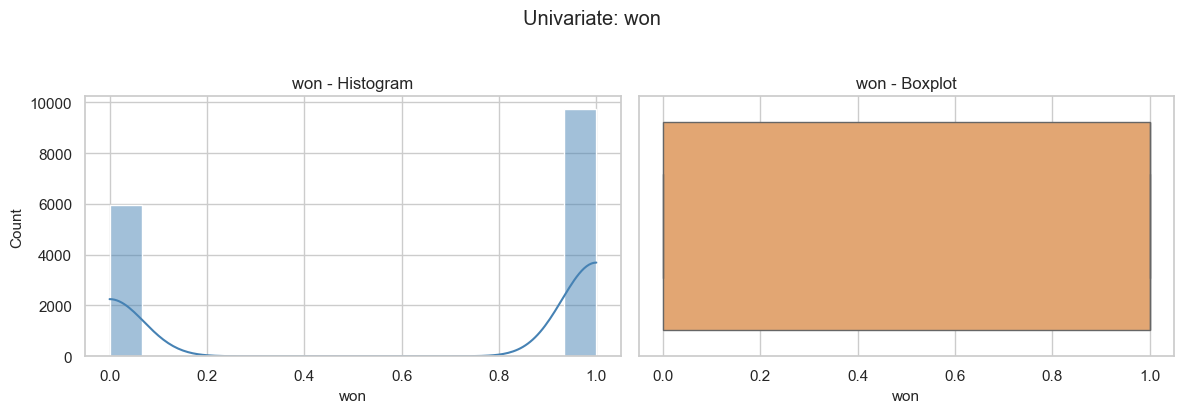

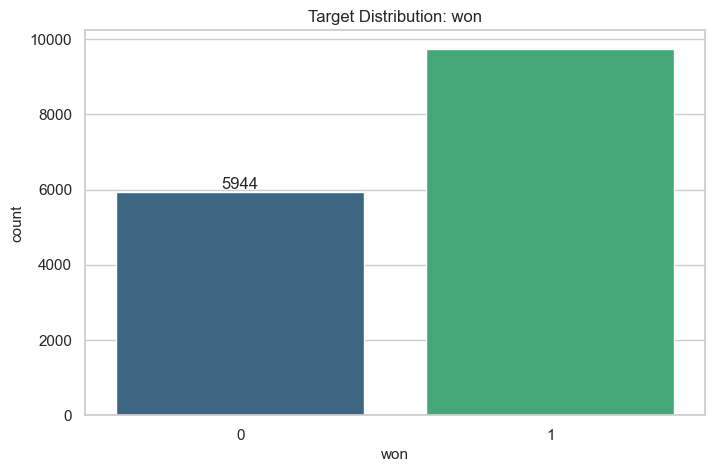

In [12]:
# Univariate distributions
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(train_df[col], kde=True, ax=axes[0], color='steelblue')
    axes[0].set_title(f'{col} - Histogram')
    sns.boxplot(x=train_df[col], ax=axes[1], color='sandybrown')
    axes[1].set_title(f'{col} - Boxplot')
    plt.suptitle(f'Univariate: {col}', y=1.03)
    plt.tight_layout()
    plt.show()

# Target distribution if present
if 'won' in train_df.columns:
    ax = sns.countplot(x='won', data=train_df, palette='viridis')
    ax.set_title('Target Distribution: won')
    ax.bar_label(ax.containers[0])
    plt.show()


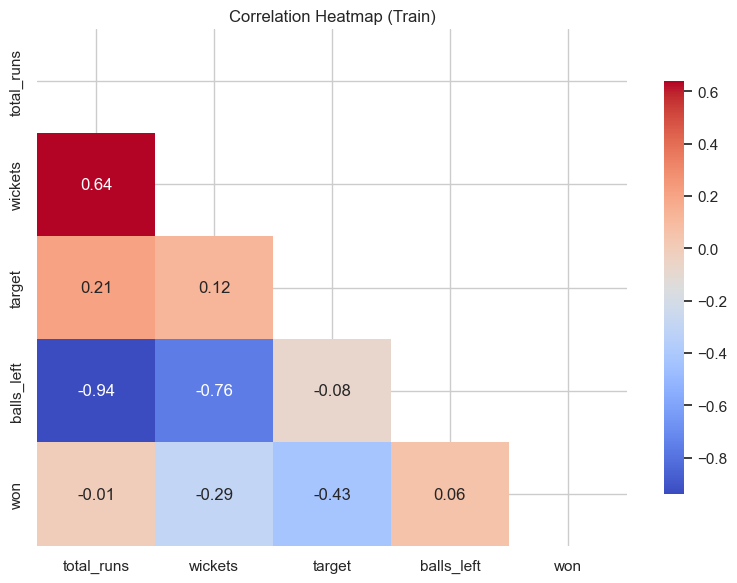

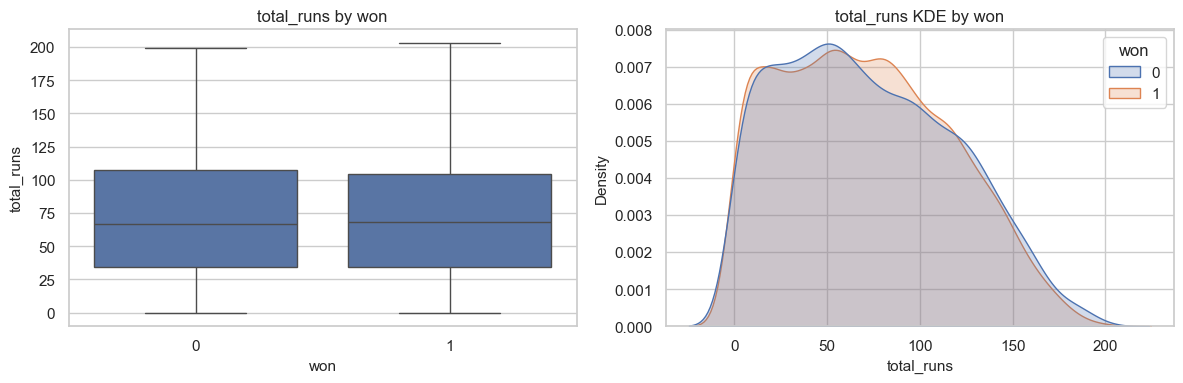

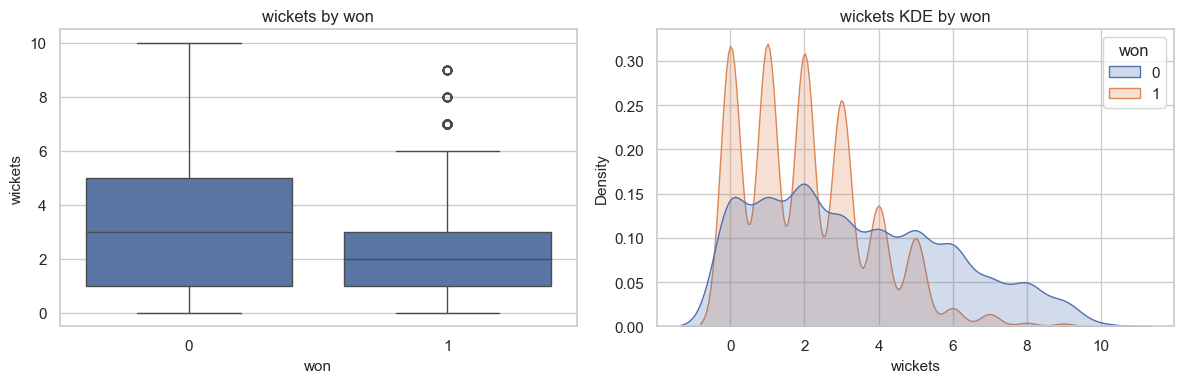

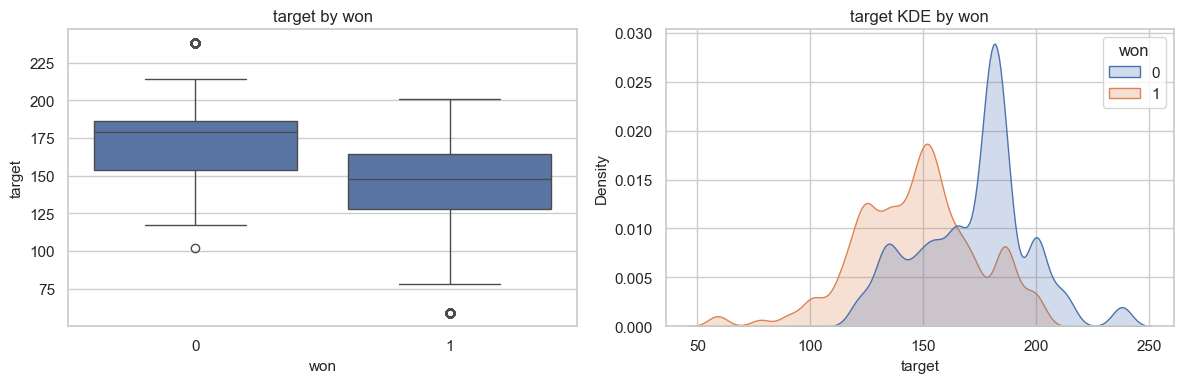

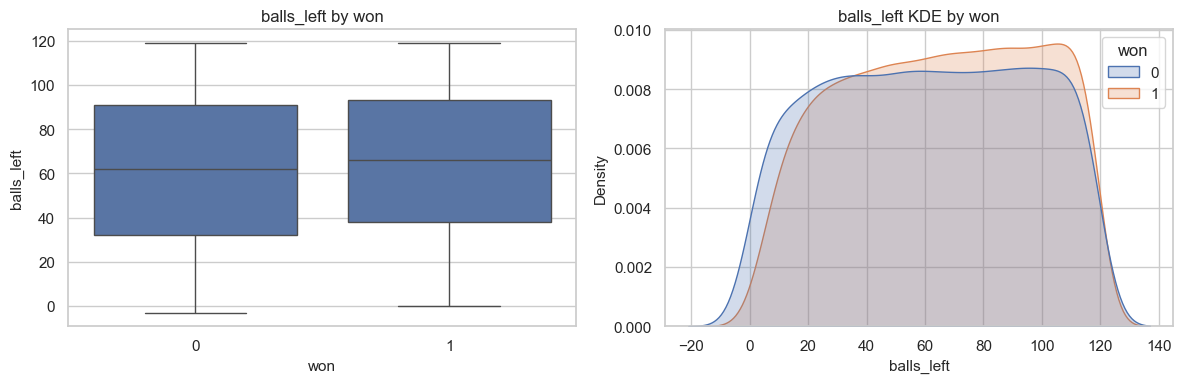

In [13]:
# Correlations
corr = train_df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8,6))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap (Train)')
plt.tight_layout()
plt.show()

# Feature vs target relationships
if 'won' in train_df.columns:
    feature_cols = [c for c in numeric_cols if c != 'won']
    for col in feature_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12,4))
        sns.boxplot(x='won', y=col, data=train_df, ax=axes[0])
        axes[0].set_title(f'{col} by won')
        sns.kdeplot(data=train_df, x=col, hue='won', common_norm=False, fill=True, ax=axes[1])
        axes[1].set_title(f'{col} KDE by won')
        plt.tight_layout()
        plt.show()


Common columns: ['total_runs', 'wickets', 'target', 'balls_left']


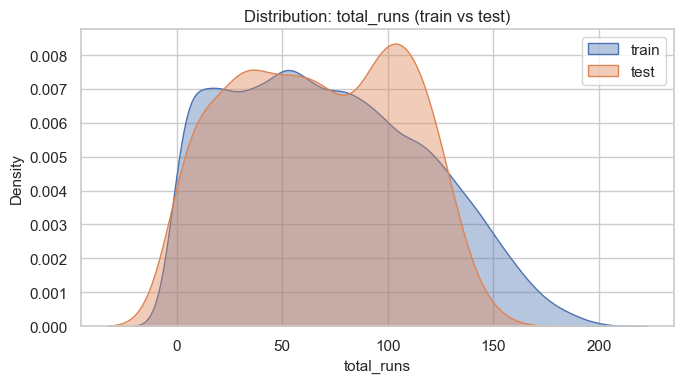

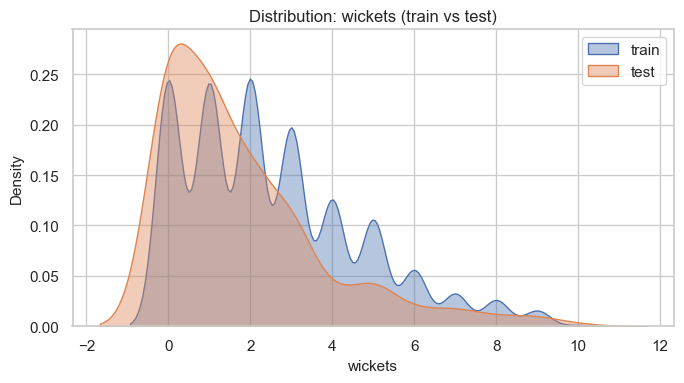

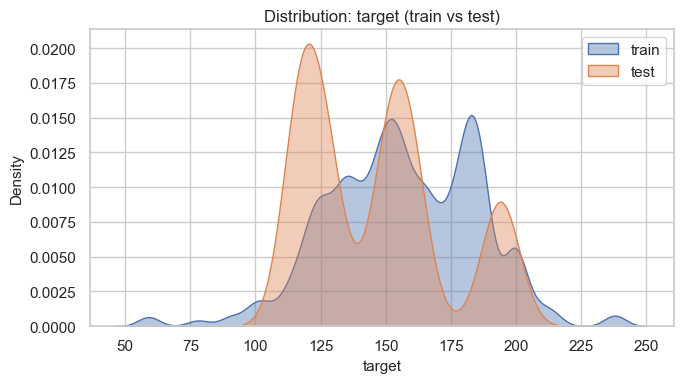

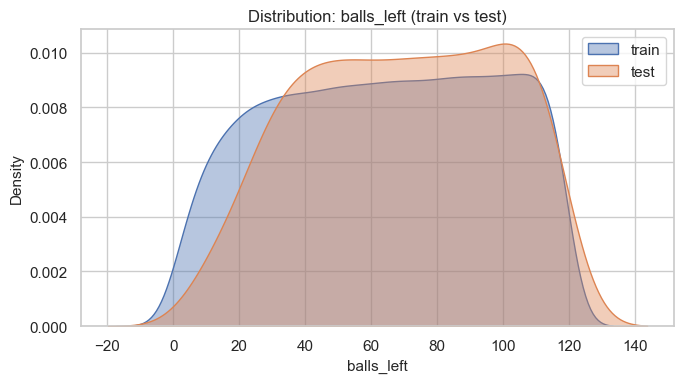

Corr(won, row_id): 0.0300


In [14]:
# Train/Test comparison and leakage checks
common_cols = [c for c in train_df.columns if c in test_df.columns]
print('Common columns:', common_cols)

# Distribution comparison for common numeric columns
for col in [c for c in common_cols if pd.api.types.is_numeric_dtype(train_df[c])]:
    fig, ax = plt.subplots(figsize=(7,4))
    sns.kdeplot(train_df[col], label='train', fill=True, alpha=0.4)
    sns.kdeplot(test_df[col], label='test', fill=True, alpha=0.4)
    ax.set_title(f'Distribution: {col} (train vs test)')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Simple leakage probe: correlation of features with target by time-like proxy if any
if 'won' in train_df.columns:
    # There is no explicit time column, but we can check if row order carries information
    train_df['_row_id'] = np.arange(len(train_df))
    leak_corr = train_df[['won','_row_id']].corr().iloc[0,1]
    print(f'Corr(won, row_id): {leak_corr:.4f}')
    train_df.drop(columns=['_row_id'], inplace=True)


## Key Insights and Notes

- The dataset includes numeric features: `total_runs`, `wickets`, `target`, `balls_left`; and target `won` in train.
- No/marginal missingness observed (see missingness output). If present, consider simple imputations.
- Strong relationships expected:
  - More `total_runs` and more `balls_left` generally increase winning chances.
  - Higher `wickets` lost should reduce winning chances.
  - Larger `target` makes chasing harder.
- Correlation heatmap and class-conditional plots provide feature importance hints.
- Train/test distributions are compared to check for covariate shift.
- No explicit time columns; low correlation to row order suggests minimal leakage risk.

Next steps:
- Feature engineering (e.g., run-rate, required-run-rate, wickets_in_hand).
- Baseline modeling with logistic regression or tree-based methods.
- Cross-validation and calibration; consider class balance techniques if needed.
